In [1]:
import numpy as np
import matplotlib.pyplot as plt
import koopman as koop
from scipy import stats
from scipy.integrate import quad 


# Rotation on a circle

The stochastic equation is: $x_{t +1} = x_t + \nu + \omega t$
where $\nu$ is a fixed rotation angle and $\omega_t\sim Uniform[-0.5, 0.5]$. The function below generates a trajectory for number of time steps T, with rotation angle $\nu$ and initial condition $x_0$.

In [2]:
def circle_rotation(x0, T, nu):
    solution  = np.zeros(T)
    solution[0] = x0
    for i in range(1, T):
        # draw random number
        omega = np.random.rand() - 0.5
        # update
        solution[i] =np.mod(solution[i - 1] + nu + omega, 2*np.pi)
    return solution

Start by plotting a trajectory

Text(0.5, 1.0, 'Circle rotations for  100 time steps')

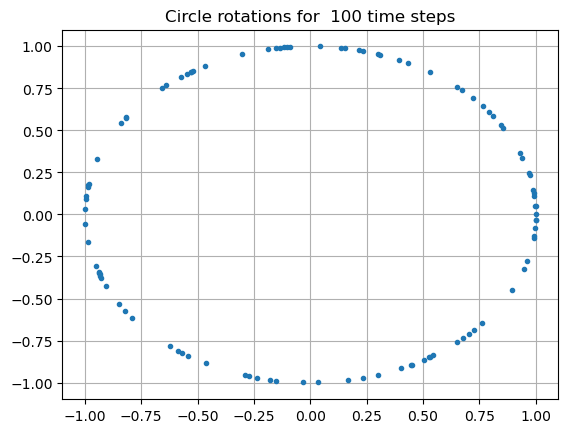

In [3]:
T = 100
rotation = circle_rotation(0, T, 0.5)
plt.plot(np.cos(rotation), np.sin(rotation), '.')
plt.grid()
plt.title('Circle rotations for  %i time steps' % T)

## L2 case
We start with densities which are normalized indicator functions on an equidistant partition of $[0, 2\pi]$ i.e.
$$g_i = 1_{\Big[i\frac{2\pi}{N},(i + 1)\frac{2\pi}{N}\Big]}, i \in \{0, \dots, N - 1\}$$

We sample K = 100 points from each measure and evolve them forward for T = 10 time steps. The data matrix is composed of the location of these $K*N$ points at time T.

First, we implemet a rejection sampling method for obtaining samples from $g_i$. We use the uniform distribution as the proposal.

In [4]:
def rejection_sample(pdf):
    while True:
        u = np.random.uniform()
        y = np.random.uniform()
        if u < pdf(y):
            return y
        

Set the hyperparameters

In [26]:
K = 101
N = 99
T = 10
nu = 0.5

Generate the data matrix by:
- sampling K points out of each of the N distributions
- propagate the points through the dynamics for time T
- record their location in the data matrix

Here we use indicators as the distributions. We split the interval $[0, 2\pi]$ in N parts, and sample uniformly on each part. 

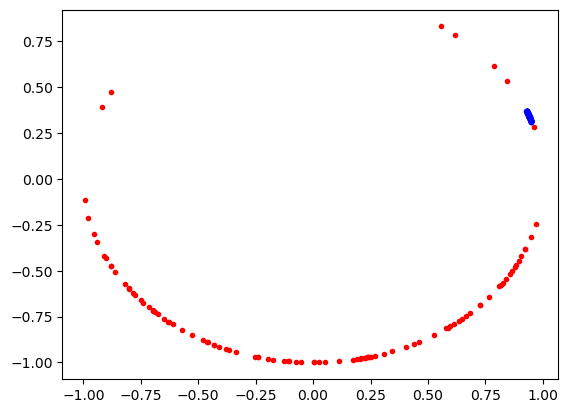

In [27]:
data = np.zeros((K, N))
data0 = np.zeros((K, N))
for i in range(N):
    # define the distributions to sample from if not uniform
    #f = lambda x:(i%2)*np.sin((i + 1)/2*x) - (i%2 - 1)*np.cos((i + 2)/2*x)
    for k in range(K):
        #x0 = rejection_sample(f)
        x0 = i* 2 * np.pi / N +  2 * np.pi / N * np.random.uniform()
        data0[k, i] = x0/(2*np.pi)

        xT = circle_rotation(x0, T, nu)
        
        # plot the samples and their images under the dynamics for specific measure 

        if i == 5:
            plt.plot(np.cos(x0), np.sin(x0), 'b.')
            plt.plot(np.cos(xT[-1]), np.sin(xT[-1]), 'r.')
        data[k, i] = xT[-1]/(2*np.pi)

Visualize the data as distributions on [0, 1]. We plot only a couple of distributions and their images under the transfer operator:

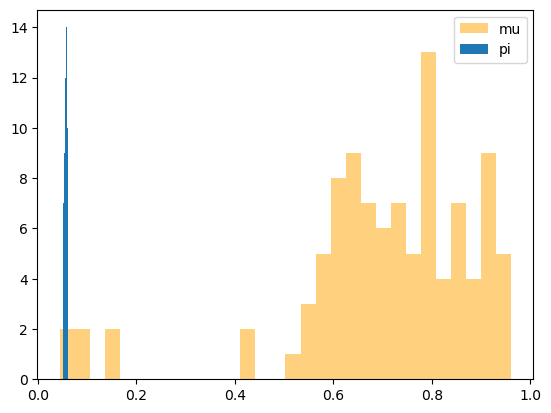

In [28]:
plt.hist(data[:, 5],  bins=30, alpha=0.5, label='mu', color='orange')
plt.hist(data0[:, 5], label = 'pi')
plt.legend()


Change the generating paradigm and generate a trajectory of $M  = 1000$ points with initial position $x_0 = 0$ and plot it.

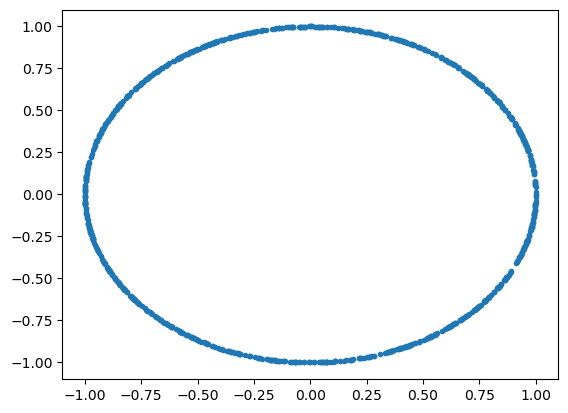

In [29]:
data_traj = circle_rotation(0, 1000, 0.5)
plt.plot(np.cos(data_traj), np.sin(data_traj), '.')

Initiate the koopman object with N = 100 basis functions of type 'indicators'. 

In [31]:
K_circle = koop.koopman(99, 'indicators')

Perform the SKO DMD algorithm on the long trajectory as a sanity check:

In [32]:
K_circle.sko(data_traj/(2*np.pi))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
evals, evects = np.linalg.eig(K_circle.mat)
evects = np.real(evects)

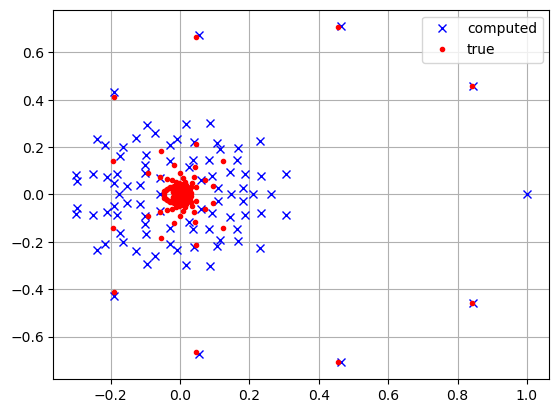

In [34]:
plt.plot(np.real(evals), np.imag(evals), 'bx', label = "computed")
plt.plot(np.sin(np.arange(1, 100))/np.arange(1, 100), ( 1 - np.cos(np.arange(1, 100)))/np.arange(1, 100), 'r.')
plt.plot(np.sin(np.arange(1, 100))/np.arange(1, 100), - ( 1 - np.cos(np.arange(1, 100)))/np.arange(1, 100), 'r.', label = "true")
plt.legend()
plt.grid()

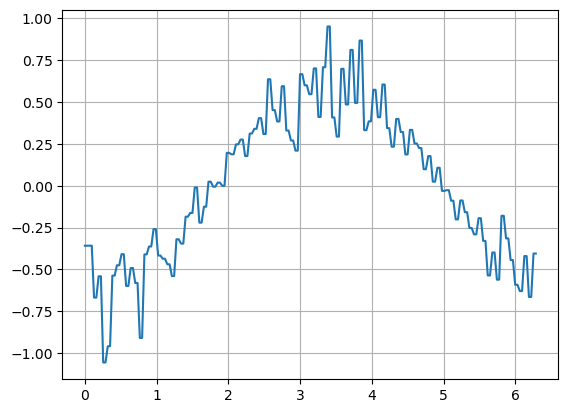

In [36]:
plt.plot(2*np.pi*np.linspace(0, 1, 99*2),2*np.pi* np.repeat(evects[:, 2], 2))
plt.grid()

In [37]:
K_circle.L2_dmd(data)

0.07920792079207921
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


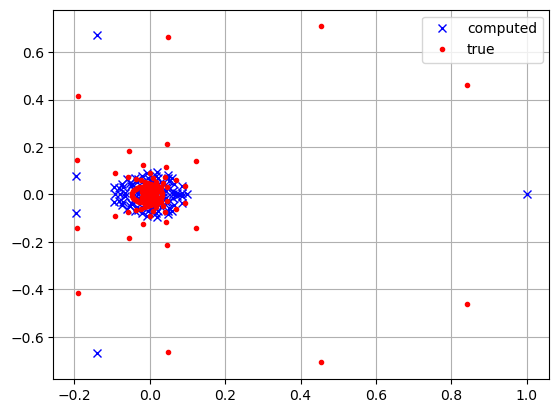

In [38]:
evals, evects = np.linalg.eig(K_circle.mat)
plt.plot(np.real(evals), np.imag(evals), 'bx', label = "computed")
plt.plot(np.sin(np.arange(1, 100))/np.arange(1, 100), ( 1 - np.cos(np.arange(1, 100)))/np.arange(1, 100), 'r.')
plt.plot(np.sin(np.arange(1, 100))/np.arange(1, 100), - ( 1 - np.cos(np.arange(1, 100)))/np.arange(1, 100), 'r.', label = "true")
plt.legend()
plt.grid()

In [49]:
D = np.zeros((N, N))
caca = 0

In [59]:
np.sum(D[:, 4])

1.0